# Figures

This notebook contains several working publication figures.

#### global import statements

In [1]:
from matplotlib import pyplot
%matplotlib inline
import pyproj

In [2]:
from os import path

In [3]:
from django.db import connection

#### supress warnings

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
from rasterio import logging

log = logging.getLogger()
log.setLevel(logging.ERROR)

#### set coordinate systems

In [6]:
austria_mgd = pyproj.Proj(init='epsg:31254')

#### function declarations

In [7]:
def get_geodataframe(queryset, modification=None, crs=austria_mgd):
    query = queryset.query.sql_with_params()
    if modification:
        query = (modification, query[1])
    return geopandas.read_postgis(query[0], connection, 
                                   geom_col='geometry', 
                                   params=query[1], 
                                   index_col='id',
                                   crs=crs)

In [8]:
def get_landcover(point, radius=100):
    buffer = point.buffer(radius)
    result = LandCover.objects.filter(geometry__intersects=buffer.envelope)\
                          .annotate(intersection=Intersection('geometry', buffer.envelope))#.aggregate(total=Collect('intersection'))
    return result

In [9]:
def save_figures(directory, figures, file_type='tiff', dpi=300):
    for figure in figures:
        eval(figure).savefig(path.join(directory, "{0}.{1}".format(figure, file_type)), dpi=dpi)

#### variable definitions

In [10]:
figure_directory = "/Users/Jake/OneDrive/Documents/alpine soundscapes/figures"

#### define formating settings

In [11]:
from matplotlib import rcParams

In [12]:
rcParams['font.sans-serif']

['Bitstream Vera Sans',
 'DejaVu Sans',
 'Lucida Grande',
 'Verdana',
 'Geneva',
 'Lucid',
 'Arial',
 'Helvetica',
 'Avant Garde',
 'sans-serif']

In [13]:
rcParams['font.sans-serif'] = ['Helvetica',
                               'Arial',
                               'Bitstream Vera Sans',
                               'DejaVu Sans',
                               'Lucida Grande',
                               'Verdana',
                               'Geneva',
                               'Lucid',
                               'Avant Garde',
                               'sans-serif']

## figure 1 — study area

#### import statements

In [14]:
import rasterio
from geo.models import LandCoverType
from landscape.models import LandCoverTypeMap
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.cm import Greys
from matplotlib.lines import Line2D

In [15]:
import numpy
import pandas
from database.models import Site
from geo.models import SampleLocation, Boundary
from geo.models import Raster
import geopandas

In [16]:
from scalebars import add_scalebar

In [17]:
def multi_annotate(ax, s, xy_list=[], *args, **kwargs):
    ans = []
    an = ax.annotate(s, xy_list[0], *args, **kwargs)
    ans.append(an)
    d = {}
    try:
        d['xycoords'] = kwargs['xycoords']
    except KeyError:
        pass
    try:
        d['arrowprops'] = kwargs['arrowprops']
    except KeyError:
        pass
    for xy in xy_list[1:]:
        an = ax.annotate(s, xy, alpha=0.0, xytext=(0,0), textcoords=an, **d)
        ans.append(an)
    return ans

In [18]:
boundary = get_geodataframe(Boundary.objects.filter(name__exact='study area'))
generated = get_geodataframe(SampleLocation.objects.all())
acutal = get_geodataframe(Site.objects.filter(id__lte=30))

In [19]:
area_percentages = pandas.read_csv("/Users/Jake/OneDrive/Documents/alpine soundscapes/data/landcover/area_percentages.csv").set_index('id')

osm roads data

In [20]:
roads_filpath = "/Users/Jake/Documents/research/alpine soundscapes/GIS/Flat_files/shapefile/highway.shp"
roads = geopandas.read_file(roads_filpath)

In [21]:
roads.Type.unique()

array(['primary', 'residential', 'footway', 'service', 'path', 'motorway',
       'track', 'unclassified', 'tertiary', 'cycleway', 'primary_link',
       'secondary', 'motorway_link', 'living_street', 'steps',
       'tertiary_link', 'pedestrian', 'secondary_link', 'construction',
       'platform', 'services', 'rest_area', 'bus_stop', 'escape',
       'elevator', 'proposed', 'crossing'], dtype=object)

In [22]:
motorway = roads[roads.Type.isin(['motorway', 'motorway_link'])]
primary = roads[roads.Type.isin(['primary', 'primary_link'])]
secondary = roads[roads.Type.isin(['secondary', 'secondary_link'])]
tertiary = roads[roads.Type.isin(['teritary', 'tertiary_link'])]
residential = roads[roads.Type == 'residential']
unclassified = roads[roads.Type == 'unclassified']

In [23]:
hillshade = Raster.objects.get(name='hillshade')
landcover = Raster.objects.get(name='landcover merged publication')
probability = Raster.objects.get(name='sample probability')

read raster data

In [24]:
with rasterio.open(path=hillshade.filepath, mode='r') as source:
    hillshade = {'data': source.read(1)}
    hillshade['extent'] = [source.bounds.left, source.bounds.right, source.bounds.bottom, source.bounds.top]
    source.close()
with rasterio.open(path=probability.filepath, mode='r') as source:
    probability = {'data': numpy.ma.masked_equal(source.read(1), value=source.nodata)}
    probability['extent'] = [source.bounds.left, source.bounds.right, source.bounds.bottom, source.bounds.top]
    source.close()
with rasterio.open(path=landcover.filepath, mode='r') as source:
    landcover = {'data': numpy.ma.masked_equal(source.read(1), value=source.nodata)}
    landcover['extent'] = [source.bounds.left, source.bounds.right, source.bounds.bottom, source.bounds.top]
    source.close()

plot

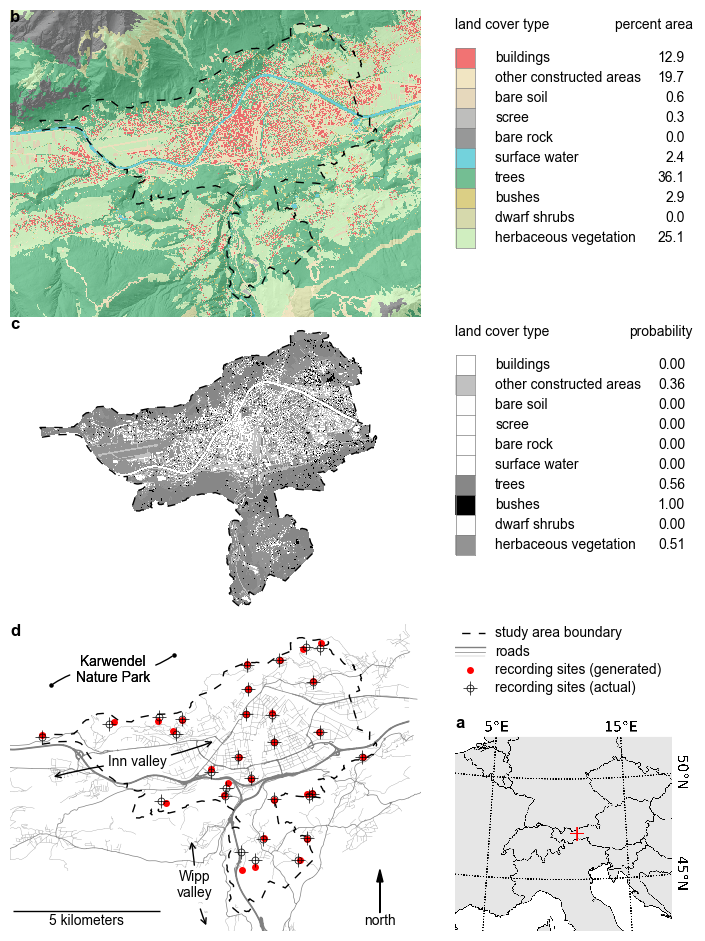

In [25]:
figure1 = pyplot.figure()
figure1.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)

figure1.set_figheight(9.21)
figure1.set_figwidth(6.85)

ax_a = pyplot.subplot2grid((30, 20), (0, 0), rowspan=10, colspan=12)
ax_l = pyplot.subplot2grid((30, 20), (0, 13), rowspan=9, colspan=7)
ax_b = pyplot.subplot2grid((30, 20), (10, 0), rowspan=10, colspan=12, sharex=ax_a, sharey=ax_a)
ax_bl = pyplot.subplot2grid((30, 20), (10, 13), rowspan=9, colspan=7, sharex=ax_l)
ax_c = pyplot.subplot2grid((30, 20), (20, 0), rowspan=10, colspan=12, sharex=ax_a, sharey=ax_a)
ax_cl = pyplot.subplot2grid((30, 20), (20, 13), rowspan=3, colspan=7, sharex=ax_l)
ax_in = pyplot.subplot2grid((30, 20), (23, 13), rowspan=7, colspan=7)

# title formatting
title_font = {
    'size': 12.0,
    'weight': 'bold'
}

# formatting
ax_a.set_frame_on(False)
ax_a.tick_params(axis='both', 
                 bottom=False, right=False, top=False, left=False,
                 labelbottom=False, labelleft=False)

# landcover colormap
color_list = [t['color'] for t in LandCoverType.objects.all().order_by('id').values()]
landcover_colormap = LinearSegmentedColormap.from_list(name='landcover', colors=color_list)

# probability colormap
prob_colormap = Greys
prob_colormap.set_under(color='white')

# plot rasters
a_hillshade = ax_a.imshow('data', extent='extent', interpolation='none', data=hillshade, cmap='gray', alpha=0.5)
a_landcover = ax_a.imshow('data', extent='extent', interpolation='none', data=landcover, cmap=landcover_colormap, vmin=1, vmax=15, alpha=0.5)
a_boundary = boundary.plot(ax=ax_a, facecolor='none', edgecolor='black', linestyle='--', linewidth=1, label='study area')

# set plot limits
ax_a.set_xlim([72500, 86500])
ax_a.set_ylim([230500, 240500])

# title
ax_a.text(0, 1, 'b', horizontalalignment='left', verticalalignment='top', 
          fontdict=title_font,
          transform=ax_a.transAxes)

#----- legend -----
type_array = numpy.array([1, 2, 3, 4, 5, 6, 9, 10, 11, 12]).reshape(10, 1)
type_array_background = numpy.ones(10).reshape(10, 1) * 0.5
ax_l.imshow(type_array_background, cmap='gray', vmin=0, vmax=1, interpolation='none', alpha=0.2)
ax_l.imshow(type_array, cmap=landcover_colormap, vmin=1, vmax=15, interpolation='none', alpha=0.5)
ax_l.set_xlim([-0.5, 11.5])
ax_l.add_line(Line2D([-0.485, -0.485], [-0.5, 9.5], color='gray', linewidth=0.5))
ax_l.add_line(Line2D([0.5, 0.5], [-0.5, 9.5], color='gray', linewidth=0.5))
for i in range(11):
    ax_l.add_line(Line2D([-0.485, 0.5], [i - 0.5, i - 0.5], color='gray', linewidth=0.5))

# formatting
ax_l.set_frame_on(False)
ax_l.set_aspect('equal')
ax_l.tick_params(axis='both', 
               bottom=False, right=False, top=False, left=False,
               labelbottom=False, labelleft=False)

# labels
for i, label in enumerate([r['name'] for r in LandCoverType.objects.filter(id__in=type_array).values()]):
    t0 = ax_l.text(1.5, i + 0.2, label.lower())
for i, a in enumerate(area_percentages['study_area'].iloc[type_array.ravel() - 1]):
    t1 = ax_l.text(11, i + 0.2, "{0:0.1f}".format(a), horizontalalignment='right')

#-------------------------------------------------------
r0 = motorway.plot(ax=ax_c, color='gray', linewidth=1)
r1 = primary.plot(ax=ax_c, color='gray', linewidth=0.5)
r2 = secondary.plot(ax=ax_c, color='gray', linewidth=0.5)
r3 = tertiary.plot(ax=ax_c, color='gray', linewidth=0.2)
r4 = residential.plot(ax=ax_c, color='gray', linewidth=0.2)
r5 = unclassified.plot(ax=ax_c, color='gray', linewidth=0.2)
p0 = boundary.plot(ax=ax_c, facecolor='none', edgecolor='black', linestyle='--', linewidth=1)
p1 = generated.plot(ax=ax_c, color='red', marker='o', alpha=1, markersize=5, markeredgecolor='none')
p2 = acutal.plot(ax=ax_c, color='black', marker='o', markersize=5, markerfacecolor='none')
p2 = acutal.plot(ax=ax_c, color='black', marker='+', markersize=10, markerfacecolor='none')
ax_c.set_frame_on(False)
ax_c.tick_params(axis='both', 
               bottom=False, right=False, top=False, left=False,
               labelbottom=False, labelleft=False)
ax_c.text(0, 1, 'd', horizontalalignment='left', verticalalignment='top', 
          fontdict=title_font, 
          transform=ax_c.transAxes)

#----- legend -----
ax_cl.tick_params(axis='both', 
               bottom=False, right=False, top=False, left=False,
               labelbottom=False, labelleft=False)
ax_cl.set_frame_on(False)
ax_cl.set_ylim([0, 1])
l3 = ax_cl.plot([-1.0, 1.0], [0.9, 0.9], color='black', markerfacecolor='none', markeredgecolor='black', linestyle='--', linewidth=1)
l3 = ax_cl.plot([-1.0, 1.0], [0.75, 0.75], color='gray', markerfacecolor='none', markeredgecolor='black', linewidth=1)
l3 = ax_cl.plot([-1.0, 1.0], [0.70, 0.70], color='gray', markerfacecolor='none', markeredgecolor='black', linewidth=0.5)
l3 = ax_cl.plot([-1.0, 1.0], [0.65, 0.65], color='gray', markerfacecolor='none', markeredgecolor='black', linewidth=0.2)
l1 = ax_cl.plot(0.25, 0.5, color='red', marker='o', alpha=1, markersize=5, markeredgecolor='none')
l2 = ax_cl.plot(0.25, 0.3, color='black', marker='o', markersize=5, markerfacecolor='none')
l3 = ax_cl.plot(0.25, 0.3, color='black', marker='+', markersize=10, markerfacecolor='none')

t1 = ax_cl.text(1.5, 0.9, 'study area boundary', va='center')
t1 = ax_cl.text(1.5, 0.7, 'roads', va='center')
t1 = ax_cl.text(1.5, 0.5, 'recording sites (generated)', va='center')
t1 = ax_cl.text(1.5, 0.3, 'recording sites (actual)', va='center')

#-------------------------------------------------------
b_probability = ax_b.imshow('data', extent='extent', interpolation='none', data=probability, cmap=prob_colormap, alpha=1, vmin=0.01, vmax=1)
b_boundary = boundary.plot(ax=ax_b, facecolor='none', edgecolor='black', linestyle='--', linewidth=1, label='study area')

#----- legend -----
probability_array = numpy.array([0, 0.3626, 0, 0, 0, 0, 0.5556, 1.0, 0, 0.5134]).reshape(10, 1)
ax_bl.imshow(probability_array, cmap=prob_colormap, vmin=0.01, vmax=1, interpolation='none')
ax_bl.set_xlim([-0.5, 11.5])
ax_bl.add_line(Line2D([-0.485, -0.485], [-0.5, 9.5], color='gray', linewidth=0.5))
ax_bl.add_line(Line2D([0.5, 0.5], [-0.5, 9.5], color='gray', linewidth=0.5))
for i in range(11):
    ax_bl.add_line(Line2D([-0.485, 0.5], [i - 0.5, i - 0.5], color='gray', linewidth=0.5))

# formatting
ax_bl.set_frame_on(False)
ax_bl.set_aspect('equal')
ax_bl.tick_params(axis='both', 
               bottom=False, right=False, top=False, left=False,
               labelbottom=False, labelleft=False)

# labels
for i, label in enumerate([r['name'] for r in LandCoverType.objects.filter(id__in=type_array).values()]):
    t0 = ax_bl.text(1.5, i + 0.2, label.lower())
for i, p in enumerate(probability_array.ravel()):
    t1 = ax_bl.text(11, i + 0.2, "{0:0.2f}".format(p), horizontalalignment='right')

# formatting
ax_b.text(0, 1, 'c', horizontalalignment='left', verticalalignment='top', 
          fontdict=title_font, 
          transform=ax_b.transAxes)
ax_b.set_frame_on(False)
ax_b.tick_params(axis='both', 
                 bottom=False, right=False, top=False, left=False,
                 labelbottom=False, labelleft=False)

scale_bar = add_scalebar(ax_c, matchx=False, matchy=False, labely=None, sizey=None, labelx='5 kilometers', sizex=5000, loc=3)
dx = 0
dy = 0.1
arrow = ax_c.arrow(0.9, 0.06, dx, dy, fc="k", ec="k", linewidth = 1, head_width=0.015, head_length=0.04, transform=ax_c.transAxes)
north = ax_c.text(0.9, 0.01, 'north', ha='center', va='bottom', transform=ax_c.transAxes)

#inset
ax_in.imshow(pyplot.imread(path.join(figure_directory, "figure1a.png")))
ax_in.text(0, 1, 'a', horizontalalignment='left', verticalalignment='top', 
          fontdict=title_font, 
          transform=ax_in.transAxes)
ax_in.set_frame_on(False)
ax_in.set_aspect('equal')
ax_in.tick_params(axis='both', 
                 bottom=False, right=False, top=False, left=False,
                 labelbottom=False, labelleft=False)

# legend titles
lt1 = ax_l.text(0, 0.93, "land cover type", transform=ax_l.transAxes)
lt2 = ax_l.text(0.99, 0.93, "percent area", horizontalalignment='right', transform=ax_l.transAxes)
lt3 = ax_bl.text(0, 0.93, "land cover type", transform=ax_bl.transAxes)
lt3 = ax_bl.text(0.99, 0.93, "probability", horizontalalignment='right', transform=ax_bl.transAxes)

# place labels
an = ax_c.annotate("Karwendel\nNature Park", xy=(0.10, 0.80), xytext=(0.25, 0.85), xycoords=ax_c.transAxes,
               ha='center', va='center', 
               arrowprops=dict(arrowstyle='-',
                               connectionstyle='arc3,rad=0.2'))
an = ax_c.annotate("Karwendel\nNature Park", xy=(0.40, 0.90), xytext=(0.25, 0.85), xycoords=ax_c.transAxes,
               ha='center', va='center', 
               arrowprops=dict(arrowstyle='-',
                               connectionstyle='arc3,rad=0.2'))
ax_c.scatter([0.1, 0.4], [0.80, 0.90], c='black', marker='o', s=5, transform=ax_c.transAxes)
bbox_props = dict(boxstyle="round,pad=0.1", fc='white', ec='white')
an = ax_c.annotate("Inn valley", xy=(0.10, 0.50), xytext=(0.31, 0.55), xycoords=ax_c.transAxes,
               ha='center', va='center', bbox=bbox_props,
               arrowprops=dict(arrowstyle='->',
                               connectionstyle='arc3,rad=0.05'))
an = ax_c.annotate("Inn valley", xy=(0.50, 0.62), xytext=(0.31, 0.55), xycoords=ax_c.transAxes,
               ha='center', va='center', bbox=bbox_props,
               arrowprops=dict(arrowstyle='->',
                               connectionstyle='arc3,rad=0.05'))
an = multi_annotate(ax_c, 'Wipp\nvalley', xy_list=[(0.44, 0.30), (0.48, 0.01)], xytext=(0.45, 0.15), xycoords=ax_c.transAxes,
               ha='center', va='center', bbox=bbox_props,
               arrowprops=dict(arrowstyle='->',
                               connectionstyle='arc3,rad=0.05'))

## Figure 2

In [26]:
import pandas
import numpy
from matplotlib import lines
from landscape.models import LandCoverTypeMap

In [27]:
from landscape.models import LandCover
from django.contrib.gis.db.models.functions import Intersection, Envelope
from django.contrib.gis.db.models import Collect
from shapely.geometry import shape

from scalebars import add_scalebar

In [28]:
site = Site.objects.get(name="Hofgarten")
modification = 'SELECT "landscape_landcover"."id", "landscape_landcover"."cover_type", ST_Intersection("landscape_landcover"."geometry", %s) AS "geometry" FROM "landscape_landcover" WHERE ST_Intersects("landscape_landcover"."geometry", %s)'
point_landcover = get_geodataframe(get_landcover(site.geometry, radius = 600),
                                   modification=modification)

radii = geopandas.GeoDataFrame([#{'name': 'recording location', 'geometry': shape(eval(site.geometry.geojson))},
                                {'name': '50m', 'geometry': shape(eval(site.geometry.buffer(50).geojson))},
                                {'name': '100m', 'geometry': shape(eval(site.geometry.buffer(100).geojson))},
                                {'name': '200m', 'geometry': shape(eval(site.geometry.buffer(200).geojson))},
                                {'name': '500m', 'geometry': shape(eval(site.geometry.buffer(500).geojson))},], 
                               index=numpy.arange(4), crs=austria_mgd, geometry='geometry')

# landcover colormap
color_list = [t['color'] for t in LandCoverType.objects.all().order_by('id').values()]
landcover_colormap = LinearSegmentedColormap.from_list(name='landcover', colors=color_list)

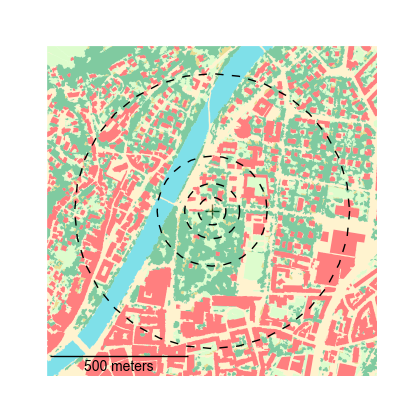

In [29]:
figure2, ax = pyplot.subplots()
#figure2.subplots_adjust(left=0.26, bottom=0.15, right=0.94, top=1, wspace=0, hspace=0)
figure2.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)

#figure2.set_dpi(1200)
figure2.set_figheight(3.30)
figure2.set_figwidth(3.30)

#a_hillshade = ax.imshow('data', extent='extent', interpolation='none', data=hillshade, cmap='gray', alpha=0.5)
p1 = point_landcover.plot(ax=ax, vmax=15, column='cover_type', edgecolor='none', cmap=landcover_colormap, alpha=0.5)
p2 = radii.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1, linestyle='--')
p3 = ax.scatter(site.geometry.coords[0], site.geometry.coords[1], marker='+', s=100, color='black', linewidths=1, alpha=1)
bbox = numpy.array(site.geometry.buffer(600).envelope.coords[0])
ax.set_xlim([bbox[:, 0].min(), bbox[:, 0].max()])
ax.set_ylim([bbox[:, 1].min(), bbox[:, 1].max()])
ax.set_frame_on(False)
ax.tick_params(axis='both', 
               bottom=False, right=False, top=False, left=False,
               labelbottom=False, labelleft=False)

x = site.geometry.coords[0]
y = site.geometry.coords[1]
#a1 = ax.annotate('200m', (x+150, y+150), xytext=(x+200, y+200), ha='center', va='center', size=12, arrowprops=ap)
#a2 = ax.annotate('500m', (x+450, y+450), xytext=(x+400, y+400), ha='center', va='center', size=12, arrowprops=ap)

scale_bar = add_scalebar(ax, matchx=False, matchy=False, labely=None, sizey=None, labelx='500 meters', sizex=500, loc=3)

ax_a2 = figure2.add_axes([0, 0.67, 1, 0.335], axisbg=(1, 1, 1, 0), frameon=False)
ax2 = figure2.add_axes([0, 0, 1, 0.665], axisbg=(1, 1, 1, 0), frameon=False)

ax_a2.tick_params(bottom=False, labelbottom=False,
                 top=False, labeltop=False,
                 left=False, labelleft=False,
                 right=False, labelright=False)
ax2.tick_params(bottom=False, labelbottom=False,
                 top=False, labeltop=False,
                 left=False, labelleft=False,
                 right=False, labelright=False)

## Figure 4

In [30]:
color_list = [t['color'] for t in LandCoverType.objects.all().order_by('id').values()]

In [31]:
area_percentages = pandas.read_csv("/Users/Jake/OneDrive/Documents/alpine soundscapes/data/landcover/area_percentages.csv").set_index('id')
area_percentages = area_percentages[['name', 'study_area', '500m', '200m', '100m', '50m']]

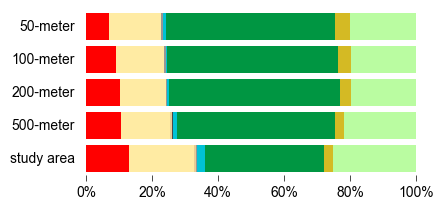

In [32]:
figure4, ax = pyplot.subplots()
figure4.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)

figure4.set_figheight(1.65)
figure4.set_figwidth(3.30)

bottoms = numpy.arange(len(area_percentages.columns) - 1) + 0.1

lefts = numpy.zeros(len(area_percentages.columns) - 1)
for i, cover_type in area_percentages.iterrows():
    widths = [cover_type[column] for column in area_percentages.columns]
    label = widths.pop(0)
    b = ax.barh(bottom=bottoms, width=widths, left=lefts, height=0.8,
               color=color_list[i - 1], edgecolor='none', label=label)
    lefts = lefts + widths
#ax2 = pyplot.axes([0,0,1,1], axisbg=(1,1,1,0))
#line = lines.Line2D([0, 0.98], [0.32, 0.32], lw=0.5, linestyle='--', color='black', )
#ax2.add_line(line)
ax.set_xlim([0, 100])
ax.set_yticks(bottoms + 0.4)
ax.set_yticklabels([s.replace('_', ' ').replace('m', '-meter') for s in area_percentages.columns.delete(0)])
ax.set_xticklabels(["{0}%".format(n) for n in range(0, 120, 20)])

ax.set_frame_on(False)
#ax2.set_frame_on(False)
ax.tick_params(axis='both', direction='out',
               bottom=True, right=False, top=False, left=False,
               labelbottom=True, labelleft=True)
#ax2.tick_params(axis='both',
#               bottom=False, right=False, top=False, left=False,
#               labelbottom=False, labelleft=False)

#-------------

## Figure 3

In [33]:
from database.models import Sound
from database.models import Site
from nacoustik import Wave
from nacoustik.spectrum import psd
from nacoustik.noise import remove_background_noise, remove_anthrophony
from scipy.io import wavfile
from datetime import timedelta
from matplotlib.patches import Rectangle

In [34]:
def multi_annotate(ax, s, xy_list=[], *args, **kwargs):
    ans = []
    an = ax.annotate(s, xy_list[0], *args, **kwargs)
    ans.append(an)
    d = {}
    try:
        d['xycoords'] = kwargs['xycoords']
    except KeyError:
        pass
    try:
        d['arrowprops'] = kwargs['arrowprops']
    except KeyError:
        pass
    for xy in xy_list[1:]:
        an = ax.annotate(s, xy, alpha=0.0, xytext=(0,0), textcoords=an, **d)
        ans.append(an)
    return ans

In [35]:
site = Site.objects.get(name='Höttinger Rain')
sound_db = Sound.objects.get(id=147)
rate, wave = wavfile.read(sound_db.get_filepath())
wave = wave[(100 * rate):(160 * rate)]
duration = 60
f, t, a_pass = psd(wave, rate=rate, window_length=512)
ale_pass = remove_background_noise(a_pass, N=0.18, iterations=3)
b_pass = remove_anthrophony(ale_pass, time_delta=t[1]-t[0], freq_delta=f[1]-f[0])

In [36]:
site = Site.objects.get(name='Pfaffensteig')
sound_db = Sound.objects.get(id=158)
rate, wave = wavfile.read(sound_db.get_filepath())
wave = wave[(0 * rate):(60 * rate)]
duration = 60
f, t, a_fail = psd(wave, rate=rate, window_length=512)
ale_fail = remove_background_noise(a_fail, N=0.18, iterations=3)
b_fail = remove_anthrophony(ale_fail, time_delta=t[1]-t[0], freq_delta=f[1]-f[0])

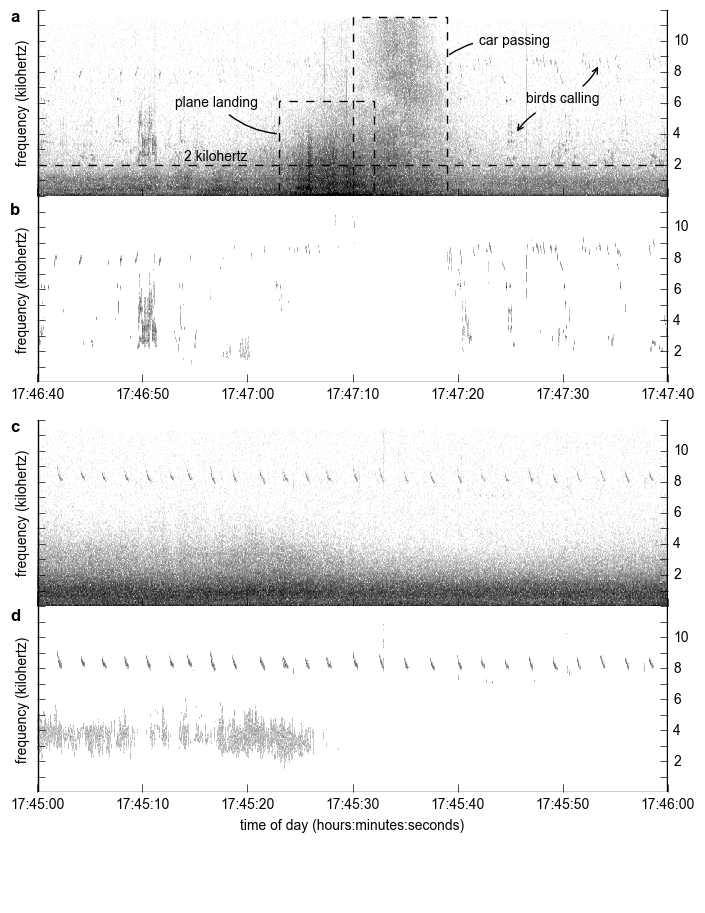

In [37]:
# configure figure
figure3 = pyplot.figure()
figure3.subplots_adjust(left=0.04, bottom=0.12, right=0.96, top=0.97, wspace=0, hspace=0)

figure3.set_figwidth(6.85)
#figure3.set_figheight(6.85 / 2)
figure3.set_figheight(9.21)

# specify frequency bins (width of 1 kiloherz)
bins = numpy.arange(0, (rate / 2), 1000)

# axes
ax_a = pyplot.subplot2grid((21, 1), (0, 0), rowspan=5, colspan=1)
ax_b = pyplot.subplot2grid((21, 1), (5, 0), rowspan=5, colspan=1, sharex=ax_a, sharey=ax_a)
ax_c = pyplot.subplot2grid((21, 1), (11, 0), rowspan=5, colspan=1, sharey=ax_a)
ax_d = pyplot.subplot2grid((21, 1), (16, 0), rowspan=5, colspan=1, sharex=ax_c, sharey=ax_a)

# compute xlabels
start_time = sound_db.get_datetime() + timedelta(seconds=100)
time_delta = 10
n = int((duration / time_delta) + 1)
xlabels_pass = [(start_time + timedelta(seconds=i*time_delta)).strftime("%H:%M:%S") for i in range(n)]
start_time = sound_db.get_datetime()
xlabels_fail = [(start_time + timedelta(seconds=i*time_delta)).strftime("%H:%M:%S") for i in range(n)]
ylabels = ["", "2", "", "4", "", "6", "", "8", "", "10", "", ""]

# original
spec_1 = ax_a.pcolormesh(t, f, a_pass[0], cmap='gray_r', vmin=-58, vmax=0)
ax_a.set(ylim=([0, rate / 2]),
         yticks = bins.astype(numpy.int) + 1000)
ax_a.set_yticklabels(ylabels)
ax_a.set_ylabel("frequency (kilohertz)")
ax_a.tick_params(length=6, color='black',
                 bottom=True, labelbottom=False,
                 top=False, labeltop=False,
                 labelleft=False,
                 labelright=True)
ax_a.set_frame_on(False)

# after adaptive level equalization
spec_2 = ax_b.pcolormesh(t, f, b_pass[0], cmap='gray_r', vmax=60)
ax_b.set(ylim=([0, rate / 2]),
              yticks = bins.astype(numpy.int) + 1000)
ax_b.set_xticklabels(xlabels_pass)
ax_b.set_ylabel("frequency (kilohertz)")
ax_b.tick_params(length=6, color='black',
                 bottom=True, labelbottom=True,
                 top=False, labeltop=False,
                 labelleft=False,
                 labelright=True)
ax_b.set_frame_on(False)

# c
spec_3 = ax_c.pcolormesh(t, f, a_fail[1], cmap='gray_r', vmin=-58, vmax=0)
ax_c.set(ylim=([0, rate / 2]),
              yticks = bins.astype(numpy.int) + 1000)
ax_c.set_ylabel("frequency (kilohertz)")
ax_c.tick_params(length=6, color='black',
                 bottom=True, labelbottom=False,
                 top=False, labeltop=False,
                 labelleft=False,
                 labelright=True)
ax_c.set_frame_on(False)

# d
spec_4 = ax_d.pcolormesh(t, f, b_fail[1], cmap='gray_r', vmax=60)
ax_d.set(ylim=([0, rate / 2]),
              yticks = bins.astype(numpy.int) + 1000)
ax_d.set_xticklabels(xlabels_fail)
ax_d.set_ylabel("frequency (kilohertz)")
ax_d.tick_params(length=6, color='black',
                 bottom=True, labelbottom=True,
                 top=False, labeltop=False,
                 labelleft=False,
                 labelright=True)
ax_d.set_frame_on(False)
ax_d.set_xlabel("time of day (hours:minutes:seconds)")

# axes borders
ax_a.add_line(lines.Line2D([t[0], t[-1:]], [1, 1], color='black', linewidth=1))
ax_a.add_line(lines.Line2D([t[0], t[0]], [0, 12000], color='black', linewidth=1))
ax_a.add_line(lines.Line2D([t[-1:], t[-1:]], [0, 12000], color='black', linewidth=1))
ax_b.add_line(lines.Line2D([t[0], t[-1:]], [1, 1], color='black', linewidth=1))
ax_b.add_line(lines.Line2D([t[0], t[0]], [0, 12000], color='black', linewidth=1))
ax_b.add_line(lines.Line2D([t[-1:], t[-1:]], [0, 12000], color='black', linewidth=1))
ax_c.add_line(lines.Line2D([t[0], t[-1:]], [1, 1], color='black', linewidth=1))
ax_c.add_line(lines.Line2D([t[0], t[0]], [0, 12000], color='black', linewidth=1))
ax_c.add_line(lines.Line2D([t[-1:], t[-1:]], [0, 12000], color='black', linewidth=1))
ax_d.add_line(lines.Line2D([t[0], t[-1:]], [1, 1], color='black', linewidth=1))
ax_d.add_line(lines.Line2D([t[0], t[0]], [0, 12000], color='black', linewidth=1))
ax_d.add_line(lines.Line2D([t[-1:], t[-1:]], [0, 12000], color='black', linewidth=1))

# annotation
ax_a.add_line(lines.Line2D([t[0], t[-1:]], [2000, 2000], color='black', linewidth=1, linestyle='--'))
t1 = ax_a.text(14, 2100, '2 kilohertz', color='black', ha='left', va='bottom')
b1 = ax_a.add_patch(Rectangle((23, 0), 9, 6100, facecolor='none', edgecolor='black', linestyle='--'))
b2 = ax_a.add_patch(Rectangle((30, 0), 9, 11500, facecolor='none', edgecolor='black', linestyle='--'))
ap = dict(arrowstyle='-',
          connectionstyle='arc3,rad=0.2')
a1 = ax_a.annotate('plane landing', (23, 4000), xytext=(21, 6000), ha='right', va='center', arrowprops=ap)
a2 = ax_a.annotate('car passing', (39, 9000), xytext=(42, 10000), ha='left', va='center', arrowprops=ap)
multi_annotate(ax_a, 'birds calling', xy_list=[(53.5, 8500), (45.5, 4000)], xytext=(50, 6300), 
               ha='center', va='center',
               arrowprops=dict(arrowstyle='->',
                               connectionstyle='arc3,rad=0.2'))

# title formatting
title_font = {
    'size': 12.0,
    'weight': 'bold'
}
ax_a2 = pyplot.axes([0, 0.5, 1, 0.47], axisbg=(1, 1, 1, 0), frameon=False)
ax_a2.tick_params(bottom=False, labelbottom=False,
                 top=False, labeltop=False,
                 left=False, labelleft=False,
                 right=False, labelright=False)
ax_b2 = pyplot.axes([0, 0, 1, 0.76], axisbg=(1, 1, 1, 0), frameon=False)
ax_b2.tick_params(bottom=False, labelbottom=False,
                 top=False, labeltop=False,
                 left=False, labelleft=False,
                 right=False, labelright=False)
ax_c2 = pyplot.axes([0, 0, 1, 0.525], axisbg=(1, 1, 1, 0), frameon=False)
ax_c2.tick_params(bottom=False, labelbottom=False,
                 top=False, labeltop=False,
                 left=False, labelleft=False,
                 right=False, labelright=False)
ax_d2 = pyplot.axes([0, 0, 1, 0.32], axisbg=(1, 1, 1, 0), frameon=False)
ax_d2.tick_params(bottom=False, labelbottom=False,
                 top=False, labeltop=False,
                 left=False, labelleft=False,
                 right=False, labelright=False)
t1 = ax_a2.text(0, 1, 'a', horizontalalignment='left', verticalalignment='top', 
          fontdict=title_font)
t2 = ax_b2.text(0, 1, 'b', horizontalalignment='left', verticalalignment='top', 
          fontdict=title_font)
t3 = ax_c2.text(0, 1, 'c', horizontalalignment='left', verticalalignment='top', 
          fontdict=title_font)
t4 = ax_d2.text(0, 1, 'd', horizontalalignment='left', verticalalignment='top', 
          fontdict=title_font)

TODO: add lat-lon, site name, and date

## Figure 9

In [38]:
from geo.models import Boundary
from geo.models import Raster

import geopandas
import rasterio
import h5py
import numpy

from scalebars import add_scalebar

In [39]:
# load biophony
h5f = h5py.File("/Users/Jake/Desktop/innsbruck_dataset/predicted_biophony.h5", 'r')
y_b = h5f['predicted_biophony'][:]
h5f.close()
# load technophony
h5f = h5py.File("/Users/Jake/Desktop/innsbruck_dataset/predicted_technophony.h5", 'r')
y_t = h5f['predicted_technophony'][:]
h5f.close()

In [40]:
coords = numpy.array(Boundary.objects.get(name = "study area").geometry.envelope.coords[0])
bbox = dict()
bbox['left'] = coords[:, 0].min() - 2000
bbox['bottom'] = coords[:, 1].min() - 2000
bbox['right'] = coords[:, 0].max() + 2000
bbox['top'] = coords[:, 1].max() + 2000
extent = [bbox['left'], bbox['right'], bbox['bottom'], bbox['top']]

In [41]:
boundary = get_geodataframe(Boundary.objects.filter(name__exact='study area'))

In [42]:
roads_filpath = "/Users/Jake/Documents/research/alpine soundscapes/GIS/Flat_files/shapefile/highway.shp"
roads = geopandas.read_file(roads_filpath)

motorway = roads[roads.Type.isin(['motorway', 'motorway_link'])]
primary = roads[roads.Type.isin(['primary', 'primary_link'])]
secondary = roads[roads.Type.isin(['secondary', 'secondary_link'])]
tertiary = roads[roads.Type.isin(['teritary', 'tertiary_link'])]
residential = roads[roads.Type == 'residential']
unclassified = roads[roads.Type == 'unclassified']

DEBUG:Fiona:Got coordinate system
INFO:Fiona:Failed to auto identify EPSG: 7
DEBUG:Fiona:Params: b'+proj=tmerc +lat_0=0 +lon_0=10.33333333333333 +k=1 +x_0=0 +y_0=-5000000 +ellps=bessel +units=m +no_defs '
DEBUG:Fiona:Index: 0


In [43]:
ae = numpy.array([y_b[0], y_b[20], y_t])

In [44]:
#TODO: improve how this works
ae_min = [ae[:2].min(), ae[:2].min(), ae[-1].min()]
ae_max = [ae[:2].max(), ae[:2].max(), ae[-1].max()]

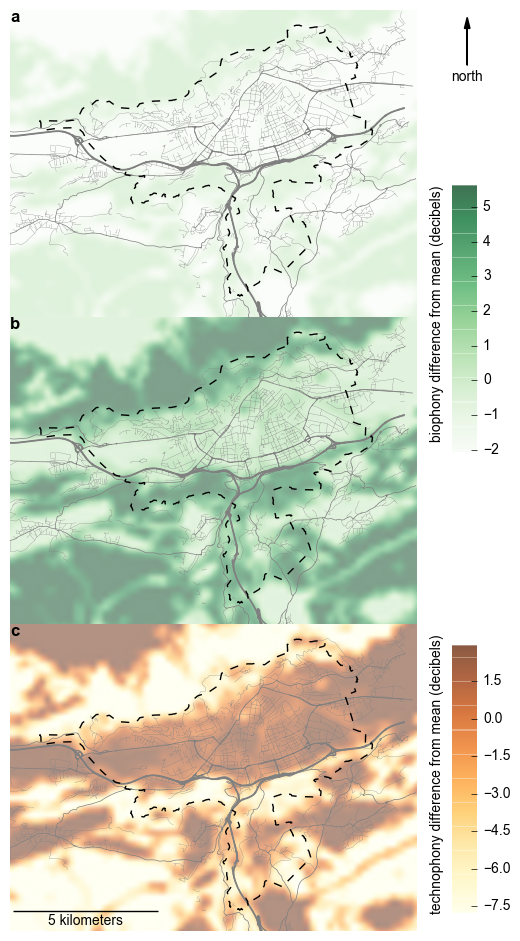

In [45]:
figure9 = pyplot.figure()

figure9.set_figwidth(5.08)
figure9.set_figheight(9.21)

figure9.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)

ax_a = pyplot.subplot2grid((30, 30), (0, 0), rowspan=10, colspan=24)
ax_b = pyplot.subplot2grid((30, 30), (10, 0), rowspan=10, colspan=24, sharex=ax_a, sharey=ax_a)
ax_c = pyplot.subplot2grid((30, 30), (20, 0), rowspan=10, colspan=24, sharex=ax_a, sharey=ax_a)

axs = [ax_a, ax_b, ax_c]

# title formatting
title_font = {
    'size': 12.0,
    'weight': 'bold'
}

# set plot limits
ax_a.set_xlim([72500, 86500])
ax_a.set_ylim([230500, 240500])

# loop through axs
ax_labels = ['a', 'b', 'c']
ae_mapables = []
for i, ax in enumerate(axs):
    ax.set_aspect('equal')
    ax.set_frame_on(False)
    ax.tick_params(axis='both', 
                   bottom=False, right=False, top=False, left=False,
                   labelbottom=False, labelleft=False)
    # roads background
    r0 = motorway.plot(ax=ax, color='gray', linewidth=1)
    r1 = primary.plot(ax=ax, color='gray', linewidth=0.5)
    r2 = secondary.plot(ax=ax, color='gray', linewidth=0.5)
    r3 = tertiary.plot(ax=ax, color='gray', linewidth=0.2)
    r4 = residential.plot(ax=ax, color='gray', linewidth=0.2)
    r5 = unclassified.plot(ax=ax, color='gray', linewidth=0.2)
    # acoustic enviorment
    if i in [0, 1]:
        cmap = 'Greens'
    else:
        cmap = 'YlOrBr'
    data = ae[i]
    vmin = ae_min[i]
    vmax = ae_max[i]
    ae_mapables.append(ax.imshow(data, cmap=cmap, origin='lower', interpolation='spline16', vmin=vmin, vmax=vmax, extent=extent, alpha=0.5))
    # boundary
    p0 = boundary.plot(ax=ax, facecolor='none', edgecolor='black', linestyle='--', linewidth=1)
    # title
    ax.text(0, 1, ax_labels[i], horizontalalignment='left', verticalalignment='top', 
              fontdict=title_font,
              transform=ax.transAxes)

# colorbars
cb_cax = figure9.add_axes([0.87, 0.52, 0.05, 0.29])
cb_b = figure9.colorbar(ae_mapables[1], cax=cb_cax, drawedges=False)
cb_b.outline.set_visible(False)
#cb_b.solids.set_edgecolor('face')

cb_cax = figure9.add_axes([0.87, 0.02, 0.05, 0.29])
cb_t = figure9.colorbar(ae_mapables[2], cax=cb_cax, drawedges=False)
#cb_t.set_alpha(0.5)
#cb_t.draw_all()
cb_t.outline.set_visible(False)

# formatting
scale_bar = add_scalebar(ax_c, matchx=False, matchy=False, labely=None, sizey=None, labelx='5 kilometers', sizex=5000, loc=3)
arrow_ax = figure9.add_axes([0.85, 0.9, 0.1, 0.1])
arrow_ax.set_frame_on(False)
arrow_ax.tick_params(axis='both', 
               bottom=False, right=False, top=False, left=False,
               labelbottom=False, labelleft=False)
dx = 0
dy = 0.4
arrow = arrow_ax.arrow(0.5, 0.4, dx, dy, fc="k", ec="k", linewidth = 1, head_width=0.11, head_length=0.12, transform=arrow_ax.transAxes)
north = arrow_ax.text(0.5, 0.2, 'north', ha='center', va='bottom', transform=arrow_ax.transAxes)

t1 = figure9.text(0.84, 0.67, "biophony difference from mean (decibels)", horizontalalignment='center', verticalalignment='center', rotation='vertical')
t2 = figure9.text(0.84, 0.17, "technophony difference from mean (decibels)", horizontalalignment='center', verticalalignment='center', rotation='vertical')

## Save figures

In [47]:
figures = [
#    'figure1',
#    'figure2',
    'figure3',
#    'figure4'
#    'figure9'
]
output_directory = "/Users/Jake/OneDrive/Documents/alpine soundscapes/figures/low resolution"
#output_directory = "/Users/Jake/Desktop/"

save_figures(output_directory, figures=figures, dpi=150)